<a href="https://colab.research.google.com/github/Anspire/Notebooks/blob/master/unet_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip '/content/drive/My Drive/data1.zip'

Archive:  /content/drive/My Drive/data1.zip
   creating: data/
   creating: data/original_images/
  inflating: data/original_images/6010_1_2.jpg  
  inflating: data/original_images/6010_4_2.jpg  
  inflating: data/original_images/6010_4_4.jpg  
  inflating: data/original_images/6040_1_0.jpg  
  inflating: data/original_images/6040_1_3.jpg  
  inflating: data/original_images/6040_2_2.jpg  
  inflating: data/original_images/6040_4_4.jpg  
  inflating: data/original_images/6060_2_3.jpg  
  inflating: data/original_images/6070_2_3.jpg  
  inflating: data/original_images/6090_2_0.jpg  
  inflating: data/original_images/6100_1_3.jpg  
  inflating: data/original_images/6100_2_2.jpg  
  inflating: data/original_images/6100_2_3.jpg  
  inflating: data/original_images/6110_1_2.jpg  
  inflating: data/original_images/6110_3_1.jpg  
  inflating: data/original_images/6110_4_0.jpg  
  inflating: data/original_images/6120_2_0.jpg  
  inflating: data/original_images/6120_2_2.jpg  
  inflating: data/or

In [0]:
import pickle
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from unet_helpers import (dice_coef,
                          dice_coef_loss,
                          load_images,
                          split_data)
from keras.models import Model
from keras.layers import (Input,
                          Conv2D,
                          MaxPooling2D,
                          UpSampling2D,
                          Dropout,
                          Concatenate)
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [0]:
RESIZED_WIDTH=256 
RESIZED_HEIGHT=256 
ORIGINAL_IMAGE_ABSOLUTE_PATH='/content/data/original_images'
ORIGINAL_MASK_ABSOLUTE_PATH='/content/data/original_masks'
PREPROCESSED_IMAGE_ABSOLUTE_PATH='/content/data/preprocessed_images'
PREPROCESSED_MASK_ABSOLUTE_PATH='/content/data/preprocessed_masks'
MODEL_WITH_MINIMUM_LOSS_ABSOLUTE_FPATH='/content/drive/My Drive/val_loss_min_unet.hdf5'
FINAL_MODEL_ABSOLUTE_FPATH='/content/drive/My Drive/unet.hdf5'
HISTORY_ABSOLUTE_FPATH='/content/drive/My Drive/history.pickle'
BATCH_SIZE=16
NUM_EPOCHS=25
LEARNING_RATE=1e-2
EARLY_STOP_VAL_PATIENCE=25

In [0]:
def split_images(images, xmax=RESIZED_WIDTH, ymax=RESIZED_HEIGHT):
    '''
    Params: images -- numpy array representing the set of images
            xmax -- the desired width of each of the output image
            ymax -- the desired height of each of the output images

    Returns: imgarr -- a numpy array of the input images split and resized
                       to the given width and height.
    '''
    imtotal = len(images)
    imshape = images[0].shape
    xnum = int(imshape[0] / xmax)
    ynum = int(imshape[1] / ymax)
    inum = xnum * ynum
    imgarr = np.zeros((imtotal * xnum * ynum, xmax, ymax, 3), dtype='uint8')
    for num, img in enumerate(images):
        for i in range(xnum):
            for j in range(ynum):
                xstart = i * xmax
                xend = (i + 1) * xmax
                ystart = j * ymax
                yend = (j + 1) * ymax
                split_img = img[xstart:xend, ystart:yend, :]
                imgarr[num * inum + i * ynum + j] = split_img
    return imgarr


def get_images_with_masks(original_path, masked_path):
    ''' Loads the images and masks from file paths and formats them into
        numpy arrays.

        Params: original_path -- filepath to folder where original images are
                                 stored
                masked_path   -- filepath to folder where original masks which
                                 correspond to the images are stored

        Returns (tuple): imgarr -- numpy array of input images
                         masked_img_arr -- numpy array of masked images
    '''
    masks = []
    original_files = []
    for original_image in os.listdir(original_path):
        original_image_fpath = os.path.join(original_path, original_image)
        masked_images_fpath = os.path.join(masked_path,
                                           original_image[0:-4] + "_mask.jpg")
        masks.append(masked_images_fpath)
        original_files.append(original_image_fpath)

    img_sample = cv2.imread(original_files[0])
    xmax, ymax, channels = img_sample.shape

    imgarr = np.zeros(shape=(len(original_files), xmax, ymax, 3),
                      dtype='uint8')
    masked_img_arr = np.zeros(shape=(len(masks), xmax, ymax, 3), dtype='uint8')
    for i, infile in enumerate(original_files):
        if infile[-4:] == 'jpeg' or infile[-3:] == 'jpg':
            img = cv2.imread(infile)
            img = cv2.resize(img, (ymax, xmax))
            imgarr[i, :] = img

            masked_infile = masks[i]
            masked_img = cv2.imread(masked_infile)
            masked_img = cv2.resize(masked_img, (ymax, xmax))
            masked_img_arr[i, :] = masked_img
    return imgarr, masked_img_arr


def save_split_images_and_masks(original_images_fpath,
                                masked_images_fpath,
                                split_original_fpath,
                                split_masked_fpath):
    ''' Writes out the split images and masks to specified folders.

    Params: original_images_fpath -- string of filepath to folder where the
                                     original images are stored.
            masked_images_fpath   -- filepath to folder where the masked
                                     images are stored.
            split_original_fpath  -- filepath where the
                                     split images should go. This folder should
                                     be created but empty.
            split_masked_fpath    -- filepath where the split masks should go.
                                     This folder should be created but empty.

    Returns: None. Writes the updated images and masks to the specified folders
    '''

    input_images, masked_input_images = get_images_with_masks(
                                                        original_images_fpath,
                                                        masked_images_fpath)
    train_images = split_images(input_images)
    masked_train_images = split_images(masked_input_images)

    zipped_images = list(zip(masked_train_images, train_images))

    for i, imgs in enumerate(zipped_images):
        cv2.imwrite(os.path.join(split_masked_fpath,
                                 "masked_" + str(i) + ".jpg"),
                    imgs[0])
        cv2.imwrite(os.path.join(split_original_fpath,
                                 "original_" + str(i) + ".jpg"),
                    imgs[1])

In [0]:
save_split_images_and_masks(ORIGINAL_IMAGE_ABSOLUTE_PATH,
                            ORIGINAL_MASK_ABSOLUTE_PATH,
                            PREPROCESSED_IMAGE_ABSOLUTE_PATH,
                            PREPROCESSED_MASK_ABSOLUTE_PATH)

In [0]:
def unet(input_shape):
    '''
    Params: input_shape -- the shape of the images that are input to the model
                           in the form (width_or_height, width_or_height,
                           num_color_channels)

    Returns: model -- a model that has been defined, but not yet compiled.
                      The model is an implementation of the Unet paper
                      (https://arxiv.org/pdf/1505.04597.pdf) and comes
                      from this repo https://github.com/zhixuhao/unet. It has
                      been modified to keep up with API changes in keras 2.
    '''
    inputs = Input(input_shape)

    conv1 = Conv2D(64,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = UpSampling2D(size=(2, 2))(drop5)
    up6 = Conv2D(512,
                 2,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(up6)
    merge6 = Concatenate(axis=3)([drop4, up6])
    conv6 = Conv2D(512,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(256,
                 2,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(up7)
    merge7 = Concatenate(axis=3)([conv3, up7])
    conv7 = Conv2D(256,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = Conv2D(128,
                 2,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(up8)
    merge8 = Concatenate(axis=3)([conv2, up8])
    conv8 = Conv2D(128,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = Conv2D(64,
                 2,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(up9)
    merge9 = Concatenate(axis=3)([conv1, up9])
    conv9 = Conv2D(64,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    return model

In [0]:
def train(input_shape,
          image_dir,
          mask_dir,
          val_loss_min_fpath,
          final_model_output_fpath,
          history_output_fpath,
          batch_size,
          num_epochs,
          learning_rate,
          early_stop_val_patience):
    '''Trains the unet model, saving the model+weights that performs the
       best on the validation set after each epoch (if there is improvement)
       as well as the final model+weights at the last epoch,
       regardless of performance. History is pickeled once training is
       finished.

    Params: input_shape -- the shape of one image in the dataset,
                           for instance (512, 512, 3)
            batch_size -- the number of images to be processed together
                          in one step through the model
            num_epochs -- the number of times the entire data set is passed
                          through the model
                          (1 epoch=(num steps through the model)*(batch_size))
            learning_rate -- a scaler value that controls how much the
                             weights get updated in the descent
            early_stop_val_patience -- number of epochs to stop training after
                                       if no improvement on the validation
                                       dataset occurs
            val_loss_min_fpath -- the path (including file name) where the
                                  model that performed the best on the
                                  validation set should be saved
            final_model_output_fpath -- the path (including file name) where
                                        the final trained model is saved
            history_output_fpath -- the path (including file name) where
                                    the history's dictionary is saved
            image_dir -- directory of images that will be input into
                         the model (when sorted the filenames in
                         this directory must correspond to the sorted
                         filenames in mask_dir)
            mask_dir -- directory of masks that will be input into the
                        model (when sorted the filenames in this directory
                        must correspond to the sorted filenames in image_dir)

    Returns (tuple): history -- keys and values that are useful for analyzing
                                (and plotting) data collected during training
                     model -- the trained model. Note: this model likely
                              overfits to the training data. To use the most
                              performant model on the validation set,
                              refer to the model saved to 'val_loss_min_fpath'
    '''
    images, masks = load_images(image_dir, mask_dir)
    X_train, X_test, y_train, y_test = split_data(images, masks)
    X_train = X_train/255.
    X_test = X_test/255.

    model = unet(input_shape)
    model.compile(optimizer=Adam(lr=learning_rate),
                  loss=dice_coef_loss,
                  metrics=[dice_coef])
    val_loss_checkpoint = ModelCheckpoint(val_loss_min_fpath,
                                          monitor='val_loss',
                                          verbose=1,
                                          save_best_only=True,
                                          mode='min')
    early_stop = EarlyStopping(monitor='val_loss',
                               patience=early_stop_val_patience)
    history = model.fit(X_train,
                        y_train,
                        batch_size=batch_size,
                        epochs=num_epochs,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stop, val_loss_checkpoint])
    model.save(final_model_output_fpath)
    with open(history_output_fpath, 'wb') as history_file:
        pickle.dump(history.history, history_file)
    return history, model

In [0]:
history, model = train((RESIZED_WIDTH, RESIZED_HEIGHT, 3),
                       PREPROCESSED_IMAGE_ABSOLUTE_PATH,
                       PREPROCESSED_MASK_ABSOLUTE_PATH,
                       MODEL_WITH_MINIMUM_LOSS_ABSOLUTE_FPATH,
                       FINAL_MODEL_ABSOLUTE_FPATH,
                       HISTORY_ABSOLUTE_FPATH,
                       BATCH_SIZE,
                       NUM_EPOCHS,
                       LEARNING_RATE,
                       EARLY_STOP_VAL_PATIENCE)

Train on 3168 samples, validate on 1057 samples
Epoch 1/25
3168/3168 [==============================] - 436s 138ms/step - loss: 0.8021 - dice_coef: 0.1979 - val_loss: 0.8096 - val_dice_coef: 0.1904

Epoch 00001: val_loss improved from inf to 0.80961, saving model to /content/drive/My Drive/val_loss_min_unet.hdf5
Epoch 2/25
3168/3168 [==============================] - 433s 137ms/step - loss: 0.8020 - dice_coef: 0.1980 - val_loss: 0.8096 - val_dice_coef: 0.1904

Epoch 00002: val_loss did not improve from 0.80961
Epoch 3/25
3168/3168 [==============================] - 433s 137ms/step - loss: 0.8019 - dice_coef: 0.1981 - val_loss: 0.8096 - val_dice_coef: 0.1904

Epoch 00003: val_loss did not improve from 0.80961
Epoch 4/25
3168/3168 [==============================] - 434s 137ms/step - loss: 0.8019 - dice_coef: 0.1981 - val_loss: 0.8096 - val_dice_coef: 0.1904

Epoch 00004: val_loss did not improve from 0.80961
Epoch 5/25
3168/3168 [==============================] - 433s 137ms/step - loss: 

In [0]:
# split data, keeping the validation set
images, masks = load_images(PREPROCESSED_IMAGE_ABSOLUTE_PATH,
                            PREPROCESSED_MASK_ABSOLUTE_PATH)
_, X_test, _, y_test = split_data(images, masks)

In [0]:
# select how many images to predict
X_test = X_test[0:10, :, :, :]
X_test.shape

(10, 256, 256, 3)

In [0]:
# scale the images to have values between 0-1 instead of 0-255, since we trained the network on images with values 0-1
X_test = X_test/255.

In [0]:
# predict model masks
predicted_masks = model.predict(X_test)

In [0]:
# many of the values of the mask will be very close to 0 or very close to 1. (for instance 0.0000000001 or .99999999).
# map them to their proper values
reasonable_threshold = .5
predicted_masks[predicted_masks < reasonable_threshold] = 0.0
predicted_masks[predicted_masks > reasonable_threshold] = 1.0

Color Image #: 0


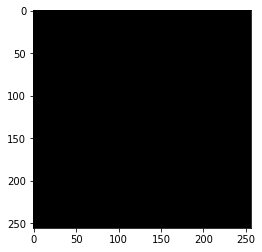

Predicted mask #: 0


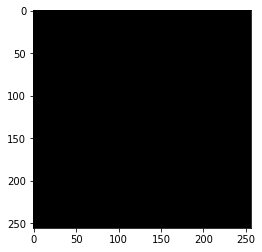

True mask #: 0


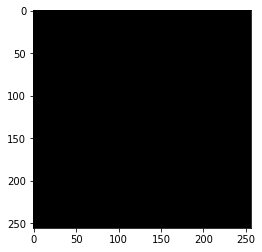

Color Image #: 1


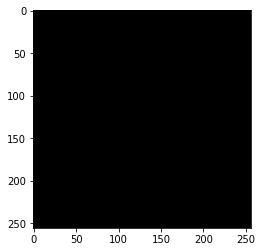

Predicted mask #: 1


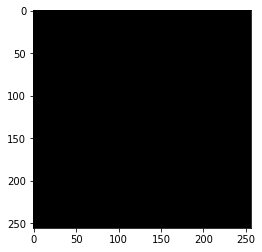

True mask #: 1


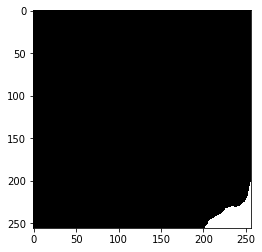

Color Image #: 2


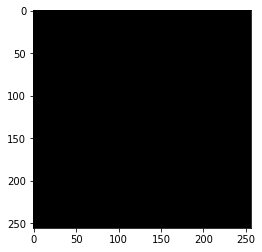

Predicted mask #: 2


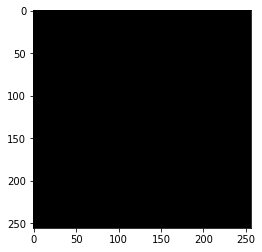

True mask #: 2


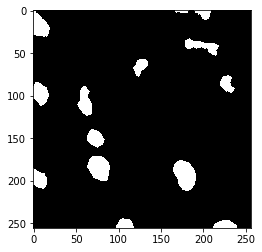

Color Image #: 3


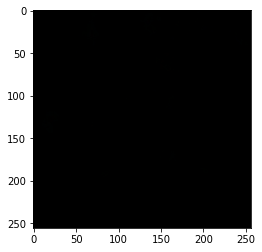

Predicted mask #: 3


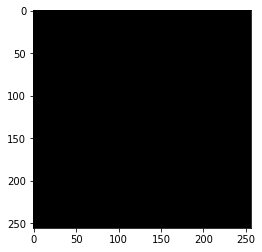

True mask #: 3


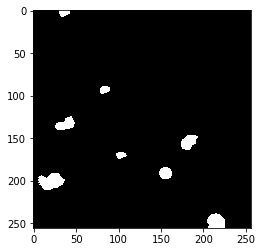

Color Image #: 4


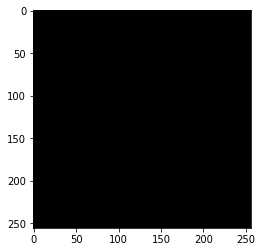

Predicted mask #: 4


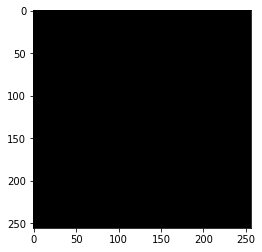

True mask #: 4


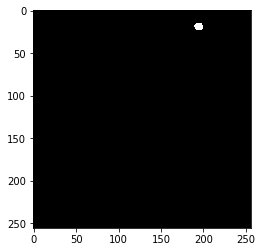

Color Image #: 5


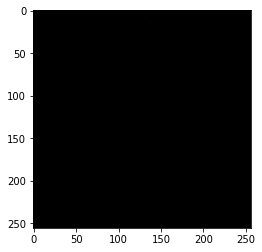

Predicted mask #: 5


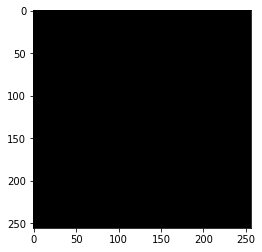

True mask #: 5


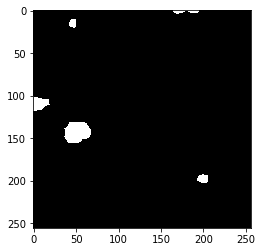

Color Image #: 6


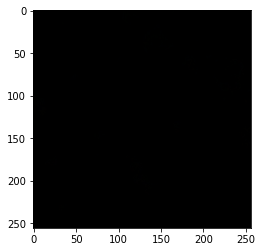

Predicted mask #: 6


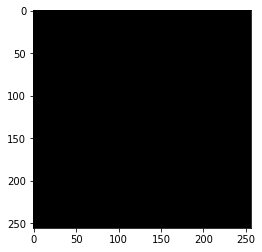

True mask #: 6


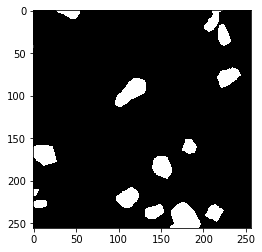

Color Image #: 7


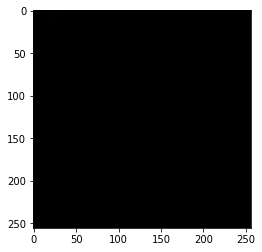

Predicted mask #: 7


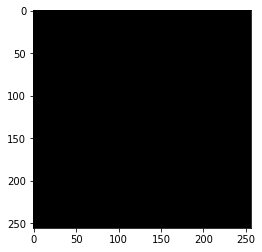

True mask #: 7


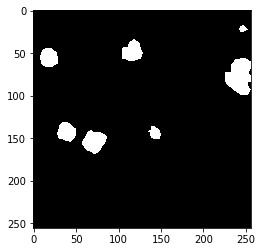

Color Image #: 8


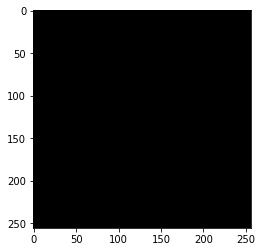

Predicted mask #: 8


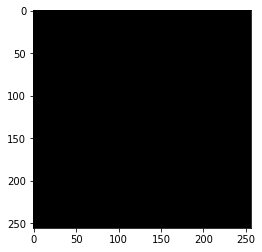

True mask #: 8


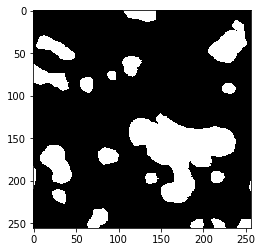

Color Image #: 9


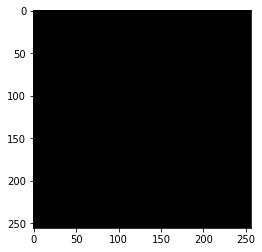

Predicted mask #: 9


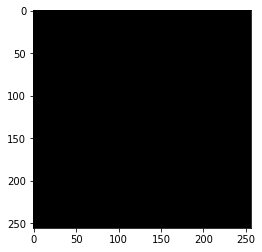

True mask #: 9


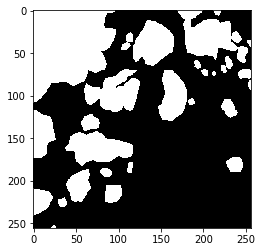

In [0]:
for i, (image_to_predict, predicted_mask, true_mask) in enumerate(zip(X_test, predicted_masks, y_test)):
    print("Color Image #: " + str(i))
    plt.imshow(image_to_predict)
    plt.show()
    print("Predicted mask #: " + str(i))
    predicted_mask = predicted_mask.reshape(RESIZED_WIDTH, RESIZED_HEIGHT)
    plt.imshow(predicted_mask, cmap='gray')
    plt.show()
    print("True mask #: " + str(i))
    true_mask = true_mask.reshape(RESIZED_WIDTH, RESIZED_HEIGHT)
    plt.imshow(true_mask, cmap='gray')
    plt.show()

In [0]:
# Read in the history for training and validation sets
with open(HISTORY_ABSOLUTE_FPATH, 'rb') as history:
    history = pickle.load(history)
    print(history)